# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando MLP.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
from ucimlrepo import fetch_ucirepo

import numpy as np
from sklearn.preprocessing import QuantileTransformer, StandardScaler
import random
import itertools


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp

### Random Search (com normalizações) e avaliação final em hold-out
import itertools, random, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import numpy as np

2025-08-21 17:48:57.664 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

y = real_estate_valuation.data.targets.to_numpy().ravel()


# -------------------------------
# Hold-out: treino/teste (fixo)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# K-fold APENAS no treino (k=5)
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=5)

### Random Search e Avaliação Melhor Caso MLP.

In [3]:

# Espaços de busca (mantive seus valores)
activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list = [100,  150, 200, 300]
hidden1_list = [4, 8, 16, 32, 64, 128, 256, 512]  # NOVO: adicionei até 256
hidden2_list = [4, 8, 16, 32, 64, 128, 256, 512]  # NOVO: adicionei até 256
learning_rates = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]  # NOVO: adicionei até 0.5
norm_options = ['zscore', 'minmax', 'iqr']  # NOVO


#### Funções auxiliares para Random Search

In [4]:

def make_scaler(name: str, n_samples: int):
    if name == 'none':
        class _NoOp:
            def fit(self, X): return self

            def transform(self, X): return X

            def fit_transform(self, X): return X

        return _NoOp()
    if name == 'zscore':
        return StandardScaler()
    if name == 'minmax':
        return MinMaxScaler()
    if name == 'iqr':
        return QuantileTransformer(
            n_quantiles=min(n_samples, 1000),
            output_distribution='uniform',
            random_state=42
        )
    raise ValueError(f"Normalização desconhecida: {name}")


def cross_val_mlp_2h(X_in, y_in, kfold, h1, h2, activation, epochs, lr, norm_name):
    """
    CV on TRAIN for MLP with two hidden layers: layer_sizes=[D, h1, h2, 1]
    - Normalizes X by `norm_name`
    - Normalizes y (StandardScaler) per fold for numerical stability
    Returns dict: means of R2, RMSE, Hit@10, Hit@20; 'valid' flag; loss histories.
    """
    layer_sizes = [X_in.shape[1], h1, h2, 1]

    fold_r2, fold_rmse, fold_h10, fold_h20 = [], [], [], []
    fold_losses = []
    valid = True

    for tr_idx, va_idx in kfold:
        X_tr, X_va = X_in[tr_idx], X_in[va_idx]
        y_tr, y_va = y_in[tr_idx].reshape(-1, 1), y_in[va_idx].reshape(-1, 1)

        # X scaler per fold
        scaler_X = make_scaler(norm_name, X_tr.shape[0])
        X_tr_n = scaler_X.fit_transform(X_tr)
        X_va_n = scaler_X.transform(X_va)

        # y scaler per fold (critical)
        y_scaler = StandardScaler()
        y_tr_s = y_scaler.fit_transform(y_tr)

        # Train
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr_s,
            layer_sizes=layer_sizes,
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)

        # Predict (invert y scaling)
        y_va_pred_s = reg_mlp.predict_mlp_regression(
            X_va_n, W, activation, 'linear'
        ).reshape(-1, 1)
        y_va_pred = y_scaler.inverse_transform(y_va_pred_s).flatten()

        # Metrics on original y
        eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_va.flatten(), y_va_pred, aux)
        metrics = [eqm, reqm, r2, hit20, hit10]
        if not all(np.isfinite(m) for m in metrics):
            valid = False
            break

        fold_r2.append(float(r2))
        fold_rmse.append(float(reqm))
        fold_h10.append(float(hit10))
        fold_h20.append(float(hit20))

    if not valid or len(fold_r2) == 0:
        return {"valid": False, "losses": fold_losses,
                "r2_mean": np.nan, "rmse_mean": np.nan, "hit10_mean": np.nan, "hit20_mean": np.nan}

    return {"valid": True, "losses": fold_losses,
            "r2_mean": float(np.mean(fold_r2)),
            "rmse_mean": float(np.mean(fold_rmse)),
            "hit10_mean": float(np.mean(fold_h10)),
            "hit20_mean": float(np.mean(fold_h20))}

def random_search_2hidden_with_norm(
    X_in, y_in, kfold,
    hidden1_list, hidden2_list,
    activations, epochs_list, lrs, norm_options,
    n_iter=40, seed=42
):
    """
    Random Search including normalization; two hidden layers.
    Selection priority: Hit@10 (desc), Hit@20 (desc), R² (desc), RMSE (asc).
    Prints progress with R², Hit@10, Hit@20; ignores numerically unstable combos.
    """
    import itertools, random, time
    random.seed(seed); np.random.seed(seed)

    all_combos = list(itertools.product(norm_options, activations, hidden1_list, hidden2_list, epochs_list, lrs))
    sampled = random.sample(all_combos, min(n_iter, len(all_combos)))
    total = len(sampled)

    def rank_key(d):
        # tuple for max(): Hit@10 desc, Hit@20 desc, R² desc, RMSE asc
        def _finite(x, neg=False):
            if x is None or not np.isfinite(x):  # NaN or inf
                return -np.inf if not neg else +np.inf
            return -x if neg else x
        return (_finite(d["hit10_mean"]),
                _finite(d["hit20_mean"]),
                _finite(d["r2_mean"]),
                _finite(d["rmse_mean"], neg=True))

    results = []
    best = None
    t0 = time.time()

    for i, (norm_name, act, h1, h2, ep, lr) in enumerate(sampled, start=1):
        # Optional safety: skip overly aggressive combos to reduce overflows
        # if max(h1, h2) >= 256 and lr >= 5e-3:
        #     print(f"[{i}/{total}] SKIP norm={norm_name} act={act} H1={h1} H2={h2} Ep={ep} LR={lr}")
        #     continue

        cv = cross_val_mlp_2h(X_in, y_in, kfold, h1, h2, act, ep, lr, norm_name)
        if cv["valid"]:
            cand = {
                "norm": norm_name, "activation": act, "h1": h1, "h2": h2,
                "epochs": ep, "lr": lr,
                "r2_mean": cv["r2_mean"],
                "rmse_mean": cv["rmse_mean"],
                "hit10_mean": cv["hit10_mean"],
                "hit20_mean": cv["hit20_mean"],
                "layer_sizes": [X_in.shape[1], h1, h2, 1]
            }
            results.append(cand)
            if best is None or rank_key(cand) > rank_key(best):
                best = cand
            msg = f"R²cv={cand['r2_mean']:.4f} | Hit@10={cand['hit10_mean']:.4f} | Hit@20={cand['hit20_mean']:.4f}"
        else:
            msg = "INVALID (overflow/NaN)"

        elapsed = time.time() - t0
        best_msg = ("N/D" if best is None else
                    f"best: Hit@10={best['hit10_mean']:.4f}, Hit@20={best['hit20_mean']:.4f}, "
                    f"R²={best['r2_mean']:.4f}, RMSE={best['rmse_mean']:.4f} "
                    f"({best['norm']},{best['activation']},H1={best['h1']},H2={best['h2']})")
        print(f"[{i}/{total}] norm={norm_name:<6} act={act:<10} H1={h1:>3} H2={h2:>3} Ep={ep:>3} LR={lr:<.3g} "
              f"→ {msg} | {best_msg} | {elapsed:.1f}s")

    if best is None:
        raise RuntimeError("All sampled combinations were unstable. Try smaller LR and/or smaller hidden sizes.")

    results_sorted = sorted(results, key=rank_key, reverse=True)
    print("\n=== TOP-10 (CV on TRAIN) — priority Hit@10 > Hit@20 > R² > RMSE ===")
    for row in results_sorted[:10]:
        print(f"{row['norm']:>6} | {row['activation']:<10} | H1={row['h1']:>3} | H2={row['h2']:>3} | "
              f"Ep={row['epochs']:>3} | LR={row['lr']:<.3g} | "
              f"R²={row['r2_mean']:.4f} | Hit@10={row['hit10_mean']:.4f} | Hit@20={row['hit20_mean']:.4f}")

    print("\n=== BEST (CV on TRAIN) — priority Hit@10 > Hit@20 > R² > RMSE ===")
    print(best)
    return best, results_sorted


### Executa Random Search no TREINO

In [5]:

# -------------------------------
# Executa Random Search no TREINO
# -------------------------------
best_cfg, cv_rank = random_search_2hidden_with_norm(
    X_train, y_train, k_fold_train,
    hidden1_list, hidden2_list,
    activations, epochs_list, learning_rates, norm_options,
    n_iter=50, seed=19
)

[1/50] norm=zscore act=sigmoid    H1=512 H2= 32 Ep=100 LR=0.005 → R²cv=0.5954 | Hit@10=0.4042 | Hit@20=0.7445 | best: Hit@10=0.4042, Hit@20=0.7445, R²=0.5954, RMSE=8.7215 (zscore,sigmoid,H1=512,H2=32) | 17.5s
[2/50] norm=iqr    act=leaky_relu H1=  4 H2=256 Ep=200 LR=0.01 → R²cv=0.6377 | Hit@10=0.4258 | Hit@20=0.7401 | best: Hit@10=0.4258, Hit@20=0.7401, R²=0.6377, RMSE=8.2938 (iqr,leaky_relu,H1=4,H2=256) | 44.0s
[3/50] norm=zscore act=relu       H1= 64 H2= 64 Ep=300 LR=0.001 → R²cv=0.6545 | Hit@10=0.4910 | Hit@20=0.7765 | best: Hit@10=0.4910, Hit@20=0.7765, R²=0.6545, RMSE=8.0847 (zscore,relu,H1=64,H2=64) | 79.8s
[4/50] norm=iqr    act=relu       H1=512 H2= 16 Ep=150 LR=0.01 → R²cv=0.6491 | Hit@10=0.4766 | Hit@20=0.7406 | best: Hit@10=0.4910, Hit@20=0.7765, R²=0.6545, RMSE=8.0847 (zscore,relu,H1=64,H2=64) | 101.3s
[5/50] norm=minmax act=sigmoid    H1= 16 H2=  4 Ep=150 LR=0.05 → R²cv=0.6465 | Hit@10=0.4471 | Hit@20=0.7697 | best: Hit@10=0.4910, Hit@20=0.7765, R²=0.6545, RMSE=8.0847 (zsc

/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:191: RuntimeWarning: invalid value encountered in multiply
  delta = error_prev * hidden_deriv(activations[i])
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)


[11/50] norm=minmax act=tanh       H1= 64 H2= 64 Ep=150 LR=0.5 → INVALID (overflow/NaN) | best: Hit@10=0.4910, Hit@20=0.7765, R²=0.6545, RMSE=8.0847 (zscore,relu,H1=64,H2=64) | 195.4s
[12/50] norm=zscore act=relu       H1= 16 H2= 32 Ep=100 LR=0.001 → R²cv=0.6685 | Hit@10=0.4762 | Hit@20=0.7768 | best: Hit@10=0.4910, Hit@20=0.7765, R²=0.6545, RMSE=8.0847 (zscore,relu,H1=64,H2=64) | 205.8s
[13/50] norm=minmax act=tanh       H1= 64 H2= 32 Ep=200 LR=0.01 → R²cv=0.6580 | Hit@10=0.5092 | Hit@20=0.7620 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 228.1s
[14/50] norm=iqr    act=sigmoid    H1=256 H2= 16 Ep=150 LR=0.01 → R²cv=0.6340 | Hit@10=0.4368 | Hit@20=0.7436 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 248.5s
[15/50] norm=minmax act=relu       H1=512 H2=256 Ep=300 LR=0.5 → R²cv=-0.4565 | Hit@10=0.2021 | Hit@20=0.3868 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) 

/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:195: RuntimeWarning: invalid value encountered in multiply
  delta = error_prev * hidden_deriv(activations[i])
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)


[17/50] norm=zscore act=relu       H1= 16 H2= 16 Ep=300 LR=0.5 → INVALID (overflow/NaN) | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 415.5s
[18/50] norm=minmax act=relu       H1=512 H2= 64 Ep=150 LR=0.05 → R²cv=0.5962 | Hit@10=0.3611 | Hit@20=0.6718 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 444.6s
[19/50] norm=minmax act=relu       H1=128 H2=  4 Ep=200 LR=0.1 → R²cv=0.4443 | Hit@10=0.3495 | Hit@20=0.5881 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 464.6s
[20/50] norm=zscore act=sigmoid    H1= 32 H2=512 Ep=100 LR=0.5 → R²cv=-0.2369 | Hit@10=0.1982 | Hit@20=0.4041 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 481.5s
[21/50] norm=minmax act=sigmoid    H1= 16 H2= 32 Ep=150 LR=0.005 → R²cv=0.5526 | Hit@10=0.3278 | Hit@20=0.6322 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) |

/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:195: RuntimeWarning: invalid value encountered in multiply
  delta = error_prev * hidden_deriv(activations[i])
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: invalid value encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabal

[24/50] norm=zscore act=relu       H1= 32 H2= 32 Ep=150 LR=0.5 → INVALID (overflow/NaN) | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 542.1s
[25/50] norm=iqr    act=leaky_relu H1= 64 H2= 64 Ep=200 LR=0.01 → R²cv=0.6384 | Hit@10=0.4769 | Hit@20=0.7510 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 565.8s
[26/50] norm=iqr    act=tanh       H1=128 H2=256 Ep=100 LR=0.005 → R²cv=0.6601 | Hit@10=0.4404 | Hit@20=0.7654 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 584.7s
[27/50] norm=iqr    act=sigmoid    H1= 16 H2= 16 Ep=200 LR=0.001 → R²cv=0.5342 | Hit@10=0.4002 | Hit@20=0.6494 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 607.0s
[28/50] norm=zscore act=tanh       H1= 64 H2= 64 Ep=200 LR=0.05 → R²cv=0.4714 | Hit@10=0.3859 | Hit@20=0.6566 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32)

/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: invalid value encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:195: RuntimeWarning: invalid value encountered in multiply
  delta = error_prev * hidden_deriv(activations[i])


[29/50] norm=zscore act=relu       H1=  4 H2=256 Ep=150 LR=0.5 → INVALID (overflow/NaN) | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 631.4s
[30/50] norm=iqr    act=sigmoid    H1=256 H2=128 Ep=300 LR=0.01 → R²cv=0.6404 | Hit@10=0.4145 | Hit@20=0.7002 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 692.0s
[31/50] norm=zscore act=sigmoid    H1= 16 H2=256 Ep=300 LR=0.1 → R²cv=0.2677 | Hit@10=0.2954 | Hit@20=0.4903 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 731.2s
[32/50] norm=zscore act=relu       H1=  4 H2=512 Ep=200 LR=0.05 → R²cv=0.4964 | Hit@10=0.4019 | Hit@20=0.6614 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 753.3s
[33/50] norm=iqr    act=tanh       H1=  4 H2=  8 Ep=300 LR=0.001 → R²cv=0.6709 | Hit@10=0.4837 | Hit@20=0.7836 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) |

/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias


[38/50] norm=zscore act=leaky_relu H1= 32 H2=  4 Ep=150 LR=0.1 → INVALID (overflow/NaN) | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 882.7s
[39/50] norm=iqr    act=sigmoid    H1=128 H2= 16 Ep=300 LR=0.01 → R²cv=0.6582 | Hit@10=0.4437 | Hit@20=0.7544 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 918.0s
[40/50] norm=minmax act=sigmoid    H1=512 H2=128 Ep=300 LR=0.05 → R²cv=0.6258 | Hit@10=0.3930 | Hit@20=0.7153 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 1002.5s
[41/50] norm=iqr    act=leaky_relu H1=128 H2=  4 Ep=150 LR=0.1 → R²cv=0.5466 | Hit@10=0.4368 | Hit@20=0.6787 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32) | 1019.0s
[42/50] norm=zscore act=relu       H1= 16 H2= 32 Ep=100 LR=0.005 → R²cv=0.6616 | Hit@10=0.4193 | Hit@20=0.7584 | best: Hit@10=0.5092, Hit@20=0.7620, R²=0.6580, RMSE=8.0760 (minmax,tanh,H1=64,H2=32)

## Análise dos resultados do Random Search


=== TEST (HOLD-OUT) ===
R² = 0.6787 | RMSE = 7.1794 | EQM = 51.5439 | Hit@10 = 0.4672 | Hit@20 = 0.8321
--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8413 ± 0.0000
Correlação Média (Teste): 0.8280 ± 0.0000
Coeficiente de Determinação (R²): 0.6787 ± 0.0000

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8043, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9354, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


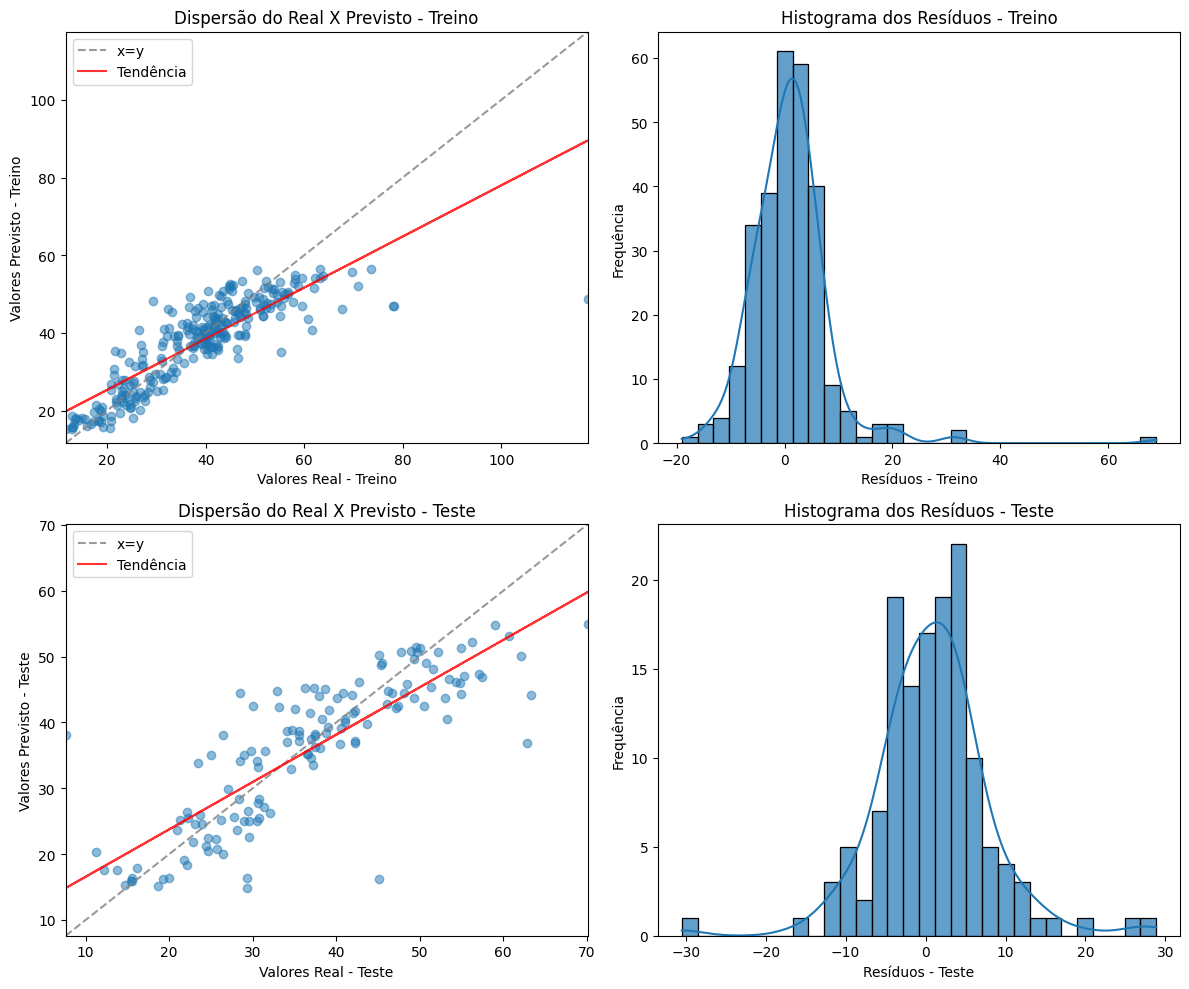

Avg. house price: 35.7700 ± 11.0052
RSME/Avg. house price: 0.1592 ± 0.2030


/home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/aux.py:334: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


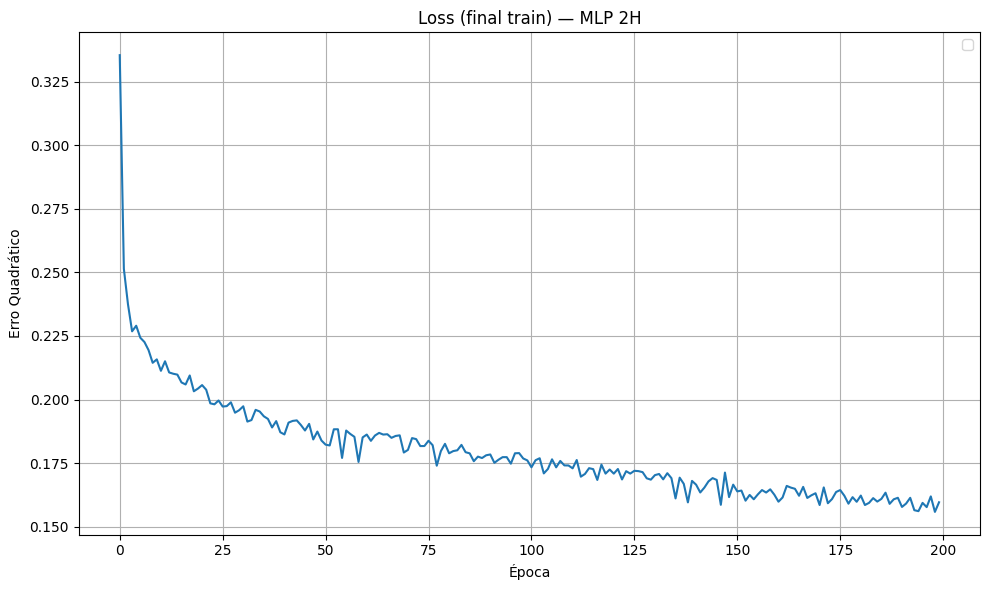

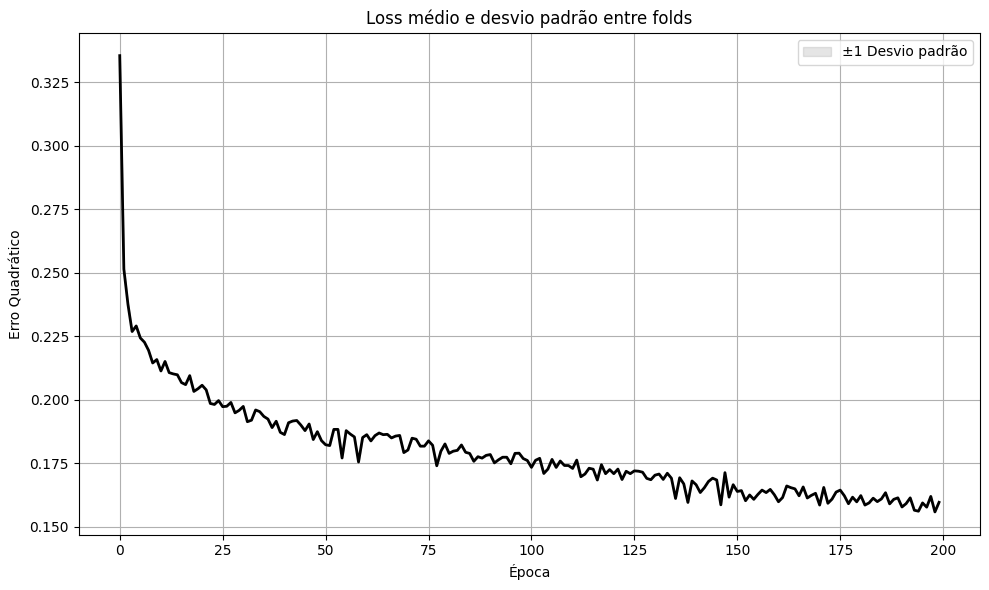

In [6]:

# ---- Final training on TRAIN + evaluation on TEST ----
norm_best = best_cfg['norm']
act_best  = best_cfg['activation']
h1_best   = best_cfg['h1']
h2_best   = best_cfg['h2']
ls_best   = [X_train.shape[1], h1_best, h2_best, 1]
ep_best   = best_cfg['epochs']
lr_best   = best_cfg['lr']

# X scaler (fit on TRAIN only)
scaler_X_final = make_scaler(norm_best, X_train.shape[0])
X_train_n = scaler_X_final.fit_transform(X_train)
X_test_n  = scaler_X_final.transform(X_test)

# y scaler (fit on TRAIN only)
scaler_y_final = StandardScaler()
y_train_s = scaler_y_final.fit_transform(y_train.reshape(-1, 1))

# Train final model
W_best, loss_hist_best = reg_mlp.train_mlp_regression(
    X_train_n, y_train_s,
    layer_sizes=ls_best,
    epochs=ep_best,
    eta_i=lr_best, eta_f=lr_best,
    hidden_activation=act_best,
    output_activation='linear',
    verbose=False
)

# Predictions (invert y scaling)
y_train_pred_s = reg_mlp.predict_mlp_regression(X_train_n, W_best, act_best, 'linear').reshape(-1, 1)
y_test_pred_s  = reg_mlp.predict_mlp_regression(X_test_n,  W_best, act_best, 'linear').reshape(-1, 1)
y_train_pred = scaler_y_final.inverse_transform(y_train_pred_s).flatten()
y_test_pred  = scaler_y_final.inverse_transform(y_test_pred_s).flatten()

# Hold-out metrics and residuals
eqm_t, rmse_t, r2_t, hit20_t, hit10_t, _ = aux.calcular_metricas(y_test, y_test_pred, aux)
print("\n=== TEST (HOLD-OUT) ===")
print(f"R² = {r2_t:.4f} | RMSE = {rmse_t:.4f} | EQM = {eqm_t:.4f} | Hit@10 = {hit10_t:.4f} | Hit@20 = {hit20_t:.4f}")

corr_tr = np.corrcoef(y_train, y_train_pred)[0, 1]
corr_te = np.corrcoef(y_test,  y_test_pred)[0, 1]
aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_t])

aux.analisar_residuos(
    y_train, y_train_pred,
    y_test,  y_test_pred,
    aux,
    titulo=f"MLP 2 Hidden — hold-out (norm={norm_best}, act={act_best}, H1={h1_best}, H2={h2_best})"
)
aux.calcular_metricas_normalizadas(y_test_pred, y_test)

aux.plot_folds_loss([loss_hist_best],
                    titulo="Loss (final train) — MLP 2H",
                    ylabel="Erro Quadrático",
                    xlabel="Época")